## Analysis of the Influence of Campaign Contributions and Incumbency on the Outcome of the 2016 House of Representatives Election Cycle

In [85]:
from warnings import simplefilter
simplefilter(action='ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns 
plt.style.use('seaborn-v0_8')
from name_cleaner import clean_names
from sklearn.metrics import *

### Data Inspection and Preparation

The two datasets imported below were obtained from the United States [Federal Election Comission](https://www.fec.gov/data/browse-data/?tab=bulk-data), and were cleaned and prepared within the notebooks entitled house_campaign_finance_data_2016_prep.ipynb and house_election_results_2016_prep.ipynb in the data_preparation directory of this repository, and will be merged to yield the datasets we will ultimately use for our analysis. Unfortunately, the FEC's electoral and campaign finance data did not overlap enough to allow simultaneous comprehensive analysis of the interrelationships among campaign contributions, votes/vote share, and electoral victory for all candidates: Many candidates listed in the financial dataset either did not progress past the primary process or for other reasons were excluded from the electoral data; and many candidates (mostly those belonging to third parties) who were included in the electoral dataset and did participate in the general election were absent from the finance data. Attempts to follow up on these discrepant data points manually were met with confirmation from the FEC that they simply did not have financial data for these latter cadidates for the election cycle under consideration. 

In light of these limitations, two datasets have been produced via two different merge procedures: A balanced, albeit rather small dataset including only those cadidates for whom **both** complete electoral and campaign finance data were available was obtained by an inner merge on candidates' FEC IDs; and another, substantially larger but more imbalanced dataset was produced using a left merge of the finance data with the electoral data on FEC ID, and includes no electoral information other than a single categorical variable indicating electoral victory or loss. 

The second dataset will serve as the focus of the parametric analyses and algorithmic classifications which follow, while the first will be analyzed in a separate notebook. It seems reasonable to expect that both will scale and complement one another nicely upon augmentation with data from additional election cycles.

In [86]:
finance = pd.read_csv('prepped_data/house_campaign_finance_data_2016.csv') 

finance[['fec_id','first_name','last_name']] = finance[['fec_id','first_name','last_name']].astype(str)

election = pd.read_csv('prepped_data/house_election_results_2016.csv')

election[['fec_id','first_name','last_name']] = election[['fec_id','first_name','last_name']].astype(str)

#### Fuzzy Matching on Names

Initial attempts at merging the two datasets on FEC ID number were largely successful, but produced some discrepancies and omissions to be addressed below. In particular, numerous candidates occurring in both appear to have both mismatched names ID numbers between the two datasets, necessitating that they be explicitly identified and manually verified via a fuzzy match on name and a cross-reference on ID, following an initial filter excluding those candidates whose respective names returned a positive fuzzy match but who campaigned in different states.

In [87]:
from rapidfuzz import fuzz

def is_similar(row, threshold=80):
    first_sim = fuzz.ratio(row['first_name_e'].lower(), row['first_name_f'].lower()) >= threshold
    last_sim = fuzz.ratio(row['last_name_e'].lower(), row['last_name_f'].lower()) >= threshold
    return first_sim and last_sim

combined = election.merge(finance, how='cross', suffixes=('_e', '_f'))

combined['similar'] = combined.apply(is_similar, axis=1)

mismatched = combined[(combined['similar']) & (combined['fec_id_e'] != combined['fec_id_f'])]

id_discrepancies_first_last = mismatched[['fec_id_e', 'first_name_e', 'last_name_e', 'state_abbr_e', 'fec_id_f', 'first_name_f', 
                                          'last_name_f', 'state_abbr_f']][mismatched['state_abbr_e']==mismatched['state_abbr_f']]

id_discrepancies_first_last 

,fec_id_e,first_name_e,last_name_e,state_abbr_e,fec_id_f,first_name_f,last_name_f,state_abbr_f
423461,H6GA04152,victor,armendariz,GA,H0GA04106,victor,armendariz,GA
488379,H6IL05168,vince,kolber,IL,H6IL05150,vince,kolber,IL
556250,H6IN06149,barry,welsh,IN,H6IN06206,barry,welsh,IN
988469,H4NH02258,jim,lawrence,NH,H6NH02238,jim,lawrence,NH
1327725,H6PA05133,kerith,taylor,PA,H4PA05062,kerith,taylor,PA
1435408,H6TN05314,steven,reynolds,TN,H6TN04200,steven,reynolds,TN
1464913,H6TX01238,shirley,mckellar,TX,H2TX01062,shirley,mckellar,TX
1516610,H6TX14124,michael,cole,TX,H2TX36134,michael,cole,TX
1681758,H6WA03234,jaime,beutler,WA,H0WA03187,jaime,beutler,WA
1687659,H6WA05171,cathy,rodgers,WA,H4WA05077,cathy,rodgers,WA


In [88]:
from rapidfuzz import fuzz
import pandas as pd

def is_similar(row, threshold=90):
    return fuzz.ratio(row['name_e'].lower(), row['name_f'].lower()) >= threshold

combined = election.merge(finance, how='cross', suffixes=('_e', '_f'))

combined['similar'] = combined.apply(is_similar, axis=1)

mismatched = combined[(combined['similar']) & (combined['fec_id_e'] != combined['fec_id_f'])]

id_discrepancies_name= mismatched[['fec_id_e', 'name_e', 'state_abbr_e', 'fec_id_f', 'name_f', 'state_abbr_f']][mismatched['state_abbr_e']==mismatched['state_abbr_f']]

id_discrepancies_name

,fec_id_e,name_e,state_abbr_e,fec_id_f,name_f,state_abbr_f
423461,H6GA04152,victor armendariz,GA,H0GA04106,victor armendariz,GA
488379,H6IL05168,vince kolber,IL,H6IL05150,vince kolber,IL
556250,H6IN06149,barry welsh,IN,H6IN06206,barry welsh,IN
988469,H4NH02258,jim lawrence,NH,H6NH02238,jim lawrence,NH
1327725,H6PA05133,kerith taylor,PA,H4PA05062,kerith taylor,PA
1435408,H6TN05314,steven reynolds,TN,H6TN04200,steven reynolds,TN
1464913,H6TX01238,shirley mckellar,TX,H2TX01062,shirley mckellar,TX
1516610,H6TX14124,michael cole,TX,H2TX36134,michael cole,TX
1681758,H6WA03234,jaime beutler,WA,H0WA03187,jaime beutler,WA
1687659,H6WA05171,cathy rodgers,WA,H4WA05077,cathy rodgers,WA


In [89]:
election.loc[election['fec_id'].isin(id_discrepancies_name['fec_id_e']),'fec_id'] = list(id_discrepancies_name['fec_id_f'])

election.loc[election['fec_id'].isin(id_discrepancies_first_last['fec_id_e']),'fec_id'] = [id for id in list(id_discrepancies_first_last['fec_id_f']) if 
                                                                                           id not in list(id_discrepancies_name['fec_id_f'])]

#### Dataset Including Campaign Finance and Complete Electoral Data

As mentioned above, the following dataset includes only those candidates who appeared on the 2016 general election ballot and for whom complete vote count and vote share data were available. It is less comprehensive (in that it captures only a small subset of electoral defeats), but is also richer, more balanced, and hopefully more informative in most respects than the larger dataset, whose observations contain only campaign finance data and a single dichotomous variable ('winner') encoding electoral victory or defeat. 

Description and analysis of this smaller dataset is carried out in the notebook entitled house_campaign_finance_analysis_with_vote_data_2016.ipynb in the root directory of this repository.

The dataset is introduced here for later use in filtering non-competing incumbents from the larger dataset, the raw data for which included incumbents who did not seek reelection to their respective House seats and were therefore not of interest to the analysis which follows despite having reported nonzero contributions to the FEC during the 2015-2016 cycle.

In [90]:
house_with_votes = pd.merge(election, finance.drop(['first_name','last_name','name','state_abbr','party'], axis='columns'), on=['fec_id'], how='inner')

house_with_votes = house_with_votes[house_with_votes['votes']!='Unopposed']

display(house_with_votes.head(), house_with_votes.info())

<class 'pandas.core.frame.DataFrame'>
Index: 772 entries, 1 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   state_abbr  772 non-null    object 
 1   state       772 non-null    object 
 2   district    772 non-null    int64  
 3   fec_id      772 non-null    object 
 4   first_name  772 non-null    object 
 5   last_name   772 non-null    object 
 6   name        772 non-null    object 
 7   party       772 non-null    object 
 8   votes       772 non-null    object 
 9   vote_share  772 non-null    float64
 10  winner      772 non-null    int64  
 11  inc         770 non-null    object 
 12  tot_rec     772 non-null    float64
dtypes: float64(2), int64(2), object(9)
memory usage: 84.4+ KB


,state_abbr,state,district,fec_id,first_name,last_name,name,party,votes,vote_share,winner,inc,tot_rec
1,AL,Alabama,2,H0AL02087,martha,roby,martha roby,Republican,134886,0.487685,1,Incumbent,1404260.12
2,AL,Alabama,2,H6AL02167,nathan,mathis,nathan mathis,Democrat,112089,0.405262,0,Challenger,36844.00
3,AL,Alabama,3,H2AL03032,mike,rogers,mike rogers,Republican,192164,0.669318,1,Incumbent,1139022.37
4,AL,Alabama,3,H4AL03061,jesse,smith,jesse smith,Democrat,94549,0.329320,0,Challenger,9810.00
6,AL,Alabama,5,H0AL05163,mo,brooks,mo brooks,Republican,205647,0.666979,1,Incumbent,476225.18


None

In [91]:
house_with_votes[['district','votes']] = house_with_votes[['district','votes']].apply(pd.to_numeric, errors='coerce', axis='columns')

print(house_with_votes.dtypes)

state_abbr     object
state          object
district        int64
fec_id         object
first_name     object
last_name      object
name           object
party          object
votes           int64
vote_share    float64
winner          int64
inc            object
tot_rec       float64
dtype: object


In [92]:
display(house_with_votes.isna().sum())

display(house_with_votes[house_with_votes['inc'].isna()])

house_with_votes.loc[house_with_votes['name']=='steve lindbeck','inc'] = 'Challenger'
house_with_votes.loc[house_with_votes['first_name']=='vaitinasa','inc'] = 'Challenger'

state_abbr    0
state         0
district      0
fec_id        0
first_name    0
last_name     0
name          0
party         0
votes         0
vote_share    0
winner        0
inc           2
tot_rec       0
dtype: int64

,state_abbr,state,district,fec_id,first_name,last_name,name,party,votes,vote_share,winner,inc,tot_rec
12,AK,Alaska,0,H6AK00235,steve,lindbeck,steve lindbeck,Democrat,111019,0.360220,0,NaN,1102309.77
14,AS,American Samoa,0,H6AS00031,vaitinasa,hunkinfinau,vaitinasa hunkinfinau,Democrat,1581,0.133598,0,NaN,41670.00


In [93]:
print('Incumbency counts:\n', house_with_votes['inc'].value_counts().reindex(['Incumbent', 'Challenger', 'Open'], fill_value=0).rename_axis('') )
print()
print('Winners:', np.shape(house_with_votes[house_with_votes['winner']==1])[0])
print('Losers:',  np.shape(house_with_votes[house_with_votes['winner']==0])[0])

Incumbency counts:
 
Incumbent     365
Challenger    312
Open           95
Name: count, dtype: int64

Winners: 412
Losers: 360


#### Larger Dataset Excluding Vote Count and Vote Share

In [94]:
house = pd.merge(finance, election[['fec_id','winner']], on='fec_id', how='left')

unopposed_ids = election[election['votes']=='Unopposed']['fec_id']

house = house[~house['fec_id'].isin(unopposed_ids)]

house['winner'] = house['winner'].fillna(0)

display(house.head(), house.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1446 entries, 0 to 1473
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   fec_id      1446 non-null   object 
 1   state_abbr  1446 non-null   object 
 2   first_name  1446 non-null   object 
 3   last_name   1446 non-null   object 
 4   name        1446 non-null   object 
 5   party       1446 non-null   object 
 6   inc         1444 non-null   object 
 7   tot_rec     1446 non-null   float64
 8   winner      1446 non-null   float64
dtypes: float64(2), object(7)
memory usage: 113.0+ KB


,fec_id,state_abbr,first_name,last_name,name,party,inc,tot_rec,winner
0,H6AK00045,AK,donald,young,donald young,Republican,Incumbent,1103561.86,1.0
1,H6AK00235,AK,steve,lindbeck,steve lindbeck,Democrat,NaN,1102309.77,0.0
3,H6AL01060,AL,larry,young,larry young,Republican,Challenger,178766.88,0.0
4,H6AL02167,AL,nathan,mathis,nathan mathis,Democrat,Challenger,36844.00,0.0
5,H0AL02087,AL,martha,roby,martha roby,Republican,Incumbent,1404260.12,1.0


None

In [95]:
display(house[house['inc'].isna()])

house.loc[house['name']=='steve lindbeck','inc'] = 'Challenger'
house.loc[house['first_name']=='vaitinasa','inc'] = 'Challenger'

display(house[house['inc'].isna()])

,fec_id,state_abbr,first_name,last_name,name,party,inc,tot_rec,winner
1,H6AK00235,AK,steve,lindbeck,steve lindbeck,Democrat,NaN,1102309.77,0.0
26,H6AS00031,AS,vaitinasa,hunkinfinau,vaitinasa hunkinfinau,Democrat,NaN,41670.00,0.0


,fec_id,state_abbr,first_name,last_name,name,party,inc,tot_rec,winner


In [96]:
print('Incumbency counts:\n', house['inc'].value_counts().reindex(['Incumbent', 'Challenger', 'Open'], fill_value=0).rename_axis('') )
print('Winners:', np.shape(house[house['winner']==1])[0])
print('Losers:',  np.shape(house[house['winner']==0])[0])

Incumbency counts:
 
Incumbent     414
Challenger    715
Open          317
Name: count, dtype: int64
Winners: 412
Losers: 1034


In [97]:
print(house_with_votes.dtypes)

house_with_votes[['district','votes']] = house_with_votes[['district','votes']].apply(pd.to_numeric, errors='coerce', axis='columns')

state_abbr     object
state          object
district        int64
fec_id         object
first_name     object
last_name      object
name           object
party          object
votes           int64
vote_share    float64
winner          int64
inc            object
tot_rec       float64
dtype: object


#### Removing Non-Competing Incumbents

As can be seen from the output of the cells below, the is a large discrepancy in incumbent count between the vote-inclusive dataset and the larger dataset is attributable to the 50 representatives who had raised campaign funds during the 2015-2016 cycle (and were therefore included in the finance data), but were either retiring from public office or were seeking a different office (and were therefore excluded from the electoral data). As this project is meant to investigate the relationship between campaign contributions and election outcomes, these candidates were excluded from the larger dataset.

In [98]:
retiree_df = pd.read_csv('raw_data/retiring_incumbents_house_2016.csv')

retiree_df = clean_names(retiree_df)

retirees = retiree_df['name']

len(retirees)

47

In [99]:
house_with_votes[house_with_votes['fec_id']=='H2FL03056']

,state_abbr,state,district,fec_id,first_name,last_name,name,party,votes,vote_share,winner,inc,tot_rec


In [100]:
display(np.shape(house[house['inc']=='Incumbent'])[0], np.shape(house_with_votes[house_with_votes['inc']=='Incumbent'])[0])

discrepant_inc_ids = list(set(house[house['inc']=='Incumbent']['fec_id']) - set(house_with_votes[house_with_votes['inc']=='Incumbent']['fec_id']))

print('Number of discrepant incumbents in finance dataset:', len(discrepant_inc_ids))

discrepant_incumbents = house[house['fec_id'].isin(discrepant_inc_ids)]['name']

414

365

Number of discrepant incumbents in finance dataset: 49


In [101]:
from rapidfuzz import fuzz
import pandas as pd

# Define a function to check fuzzy similarity
def is_similar(name1, name2, threshold=80):
    return fuzz.ratio(name1.lower(), name2.lower()) >= threshold

# Create all combinations of names between the two Series
combined = pd.DataFrame({
    'name_discrepant_incumbents': discrepant_incumbents.repeat(len(retirees)).reset_index(drop=True),
    'name_retirees': pd.concat([retirees] * len(discrepant_incumbents)).reset_index(drop=True)
})

# Apply fuzzy matching
combined['similar'] = combined.apply(
    lambda row: is_similar(row['name_discrepant_incumbents'], row['name_retirees']), axis=1
)

matches = combined[combined['similar']]


In [102]:
display(np.shape(matches)[0], matches) 

house = house[~house['name'].isin(matches['name_discrepant_incumbents'])] # Drop all fuzzy matches between retiree data and names of discrepant incumbents

df1 = retiree_df[~retiree_df['name'].isin(matches['name_retirees'])]['name'].reset_index(drop=True).sort_values()

df2 = house[house['fec_id'].isin(discrepant_inc_ids)][~house['name'].isin(matches['name_discrepant_incumbents'])]['name'].reset_index(drop=True).sort_values()

display(pd.DataFrame({'In Retiree List, Not in Finance':df1, 'In Finance, Not In Retiree List':df2}))

# View names from retiree data which did not fuzzy match any names among discrepant incumbents

41

,name_discrepant_incumbents,name_retirees,similar
27,ann kirkpatrick,ann kirkpatrick,True
61,matt salmon,matt salmon,True
116,sam farr,sam farr,True
153,lois capps,lois capps,True
227,janice hahn,janice hahn,True
268,loretta sanchez,loretta sanchez,True
320,john carney,john carney,True
337,jefferson miller,jeff miller,True
383,gwen graham,gwen graham,True
423,ander crenshaw,ander crenshaw,True


,"In Retiree List, Not in Finance","In Finance, Not In Retiree List"
0,scott rigell,corrine brown
1,alan nunnelee,kyle takai
2,ed whitfield,patrick nunnelee
3,john boehner,renee ellmers
4,mark takai,george kelly
5,michael grimm,pedro pierluisi
6,NaN,edward rigell
7,NaN,randy forbes


Of the above-listed candidates who remain after identifying the majority of the errant incumbents as retirees, none achieved reelection apart from George Joseph "Mike" Kelly.

In [103]:
house.loc[house['name']=='george kelly', 'winner'] = 1

house.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1402 entries, 0 to 1473
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   fec_id      1402 non-null   object 
 1   state_abbr  1402 non-null   object 
 2   first_name  1402 non-null   object 
 3   last_name   1402 non-null   object 
 4   name        1402 non-null   object 
 5   party       1402 non-null   object 
 6   inc         1402 non-null   object 
 7   tot_rec     1402 non-null   float64
 8   winner      1402 non-null   float64
dtypes: float64(2), object(7)
memory usage: 141.8+ KB


In [104]:
states = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 
          'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 
          'WA', 'WV', 'WI', 'WY']

house = house[house['state_abbr'].isin(states)]

### Data Description and Visualization

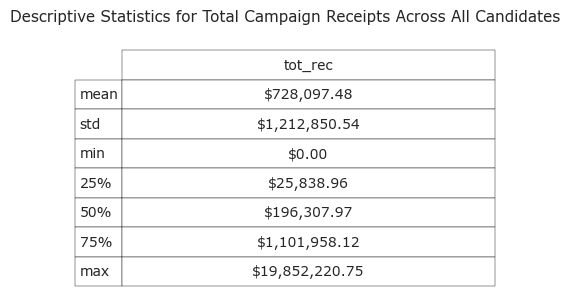

In [105]:
# d = house[['tot_rec','votes']].describe().drop(index='count')
d = house[['tot_rec']].describe().drop(index='count')

d['tot_rec'] = d['tot_rec'].apply(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
# d['votes'] = d['votes'].astype(int).apply(lambda x: f"{x:,}" if isinstance(x, (int, float)) else x)

fig, ax = plt.subplots(figsize=(4.5, 3))

ax.axis('tight')
ax.axis('off')
plt.rcParams['font.family'] = 'Verdana'

table = ax.table(
    cellText=d.values,
    colLabels=d.columns,
    rowLabels=d.index,
    loc='center',
    cellLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
fig.suptitle('Descriptive Statistics for Total Campaign Receipts Across All Candidates', fontsize=11)
fig.tight_layout()

plt.show()

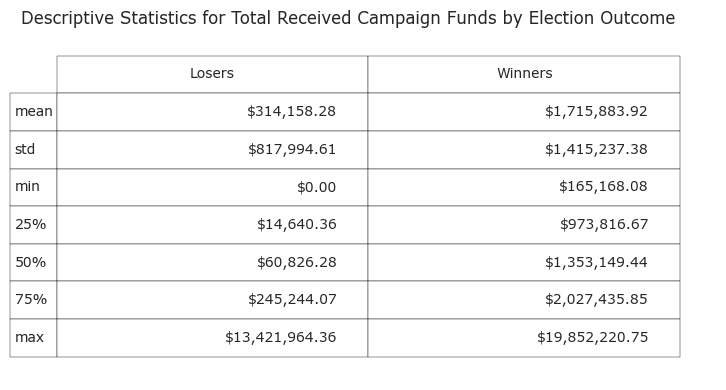

In [106]:
describe_losers = house[house['winner']==0]['tot_rec'].describe().apply(lambda x: f'${x:,.2f}' if isinstance(x, (int, float)) else x).drop('count', axis='index')

describe_winners = house[house['winner']==1]['tot_rec'].describe().apply(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x).drop('count', axis='index')

des = pd.concat([describe_losers, describe_winners], axis='columns')

fig, ax = plt.subplots(figsize=(7,4))

plt.rcParams['font.family'] = 'Verdana'
ax.axis('off'), ax.axis('tight')
table = ax.table(cellText=des.values.tolist(), rowLabels=des.index, colLabels=['Losers','Winners'], loc='center')
table.scale(1,2)
plt.title('Descriptive Statistics for Total Received Campaign Funds by Election Outcome       ')

fig.tight_layout()

Text(0, 0.5, 'Count')

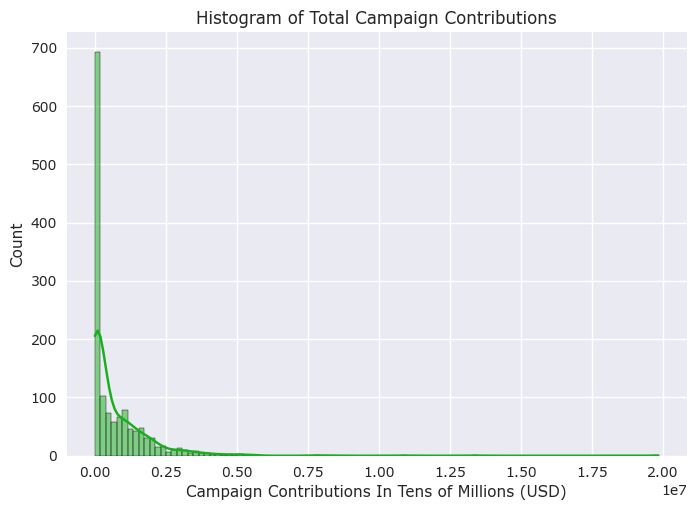

In [107]:
sns.histplot(data=house, x='tot_rec', kde=True, color='#15b01a')

plt.title('Histogram of Total Campaign Contributions')
plt.xlabel('Campaign Contributions In Tens of Millions (USD)')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

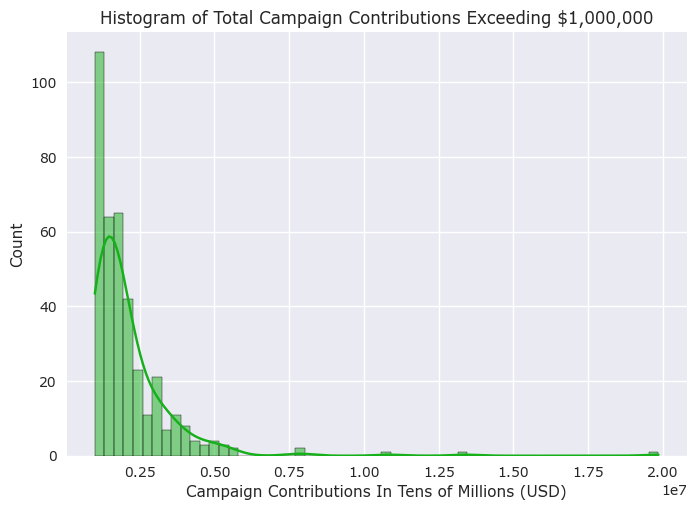

In [108]:
sns.histplot(data=house[house['tot_rec']>1000000], x='tot_rec', kde=True, color='#15b01a')

plt.title('Histogram of Total Campaign Contributions Exceeding $1,000,000')
plt.xlabel('Campaign Contributions In Tens of Millions (USD)')
plt.ylabel('Count')

([<matplotlib.axis.XTick at 0x17d1ee1b110>,
 [Text(0, 0, 'Losers'), Text(1, 0, 'Winners')])

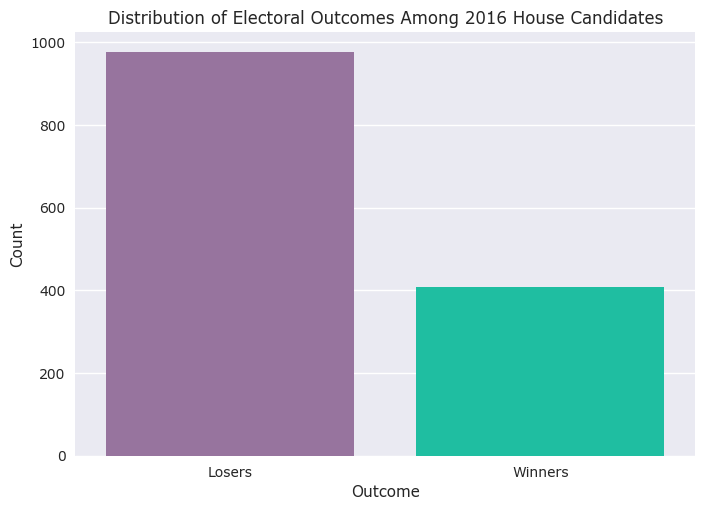

In [109]:
sns.countplot(data=house, x='winner', palette=['#9c6da5','#04d8b2'])

plt.title('Distribution of Electoral Outcomes Among 2016 House Candidates')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.xticks(ticks=[0,1], labels=['Losers','Winners'])

([<matplotlib.axis.XTick at 0x17d1ed8dbd0>,
 [Text(0, 0, 'Losers'), Text(1, 0, 'Winners')])

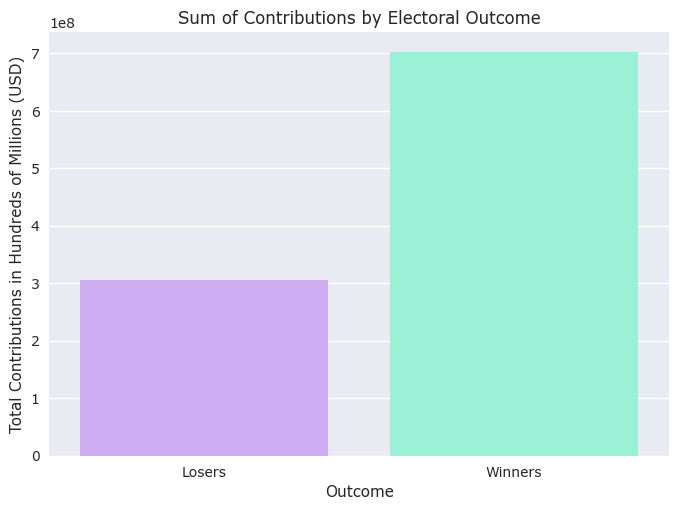

In [110]:
tot_rec_by_outcome = [house[house['winner']==0]['tot_rec'].sum(), house[house['winner']==1]['tot_rec'].sum()]

sns.barplot(x=[0,1], y=tot_rec_by_outcome, palette=['#cea2fd','#8cffdb'])

plt.title('Sum of Contributions by Electoral Outcome')
plt.xlabel('Outcome')
plt.ylabel('Total Contributions in Hundreds of Millions (USD)')
plt.xticks(ticks=[0,1], labels=['Losers','Winners'])

([<matplotlib.axis.XTick at 0x17d10a09950>,
 [Text(0, 0, 'Loss'), Text(1, 0, 'Win')])

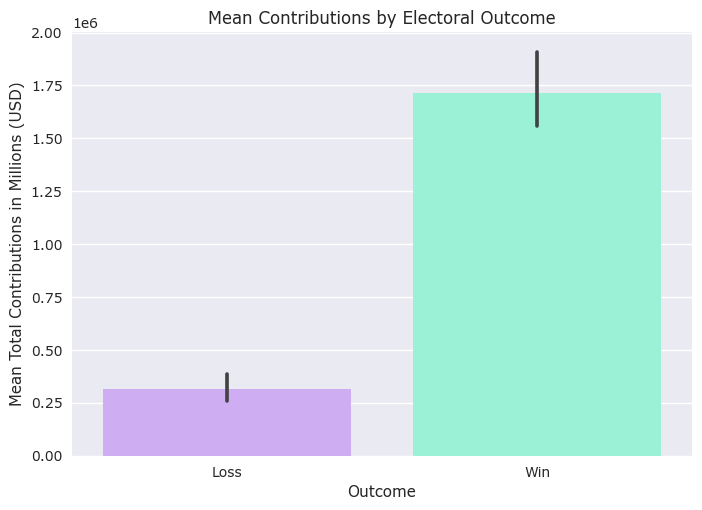

In [111]:
sns.barplot(data=house, x='winner', y='tot_rec', palette=['#cea2fd','#8cffdb'], errorbar=('ci',99))

plt.title('Mean Contributions by Electoral Outcome')
plt.xlabel('Outcome')
plt.ylabel('Mean Total Contributions in Millions (USD)')
plt.xticks(ticks=[0,1], labels=['Loss','Win'])

([<matplotlib.axis.XTick at 0x17d10999d10>,
 [Text(0, 0, 'Loss'), Text(1, 0, 'Win')])

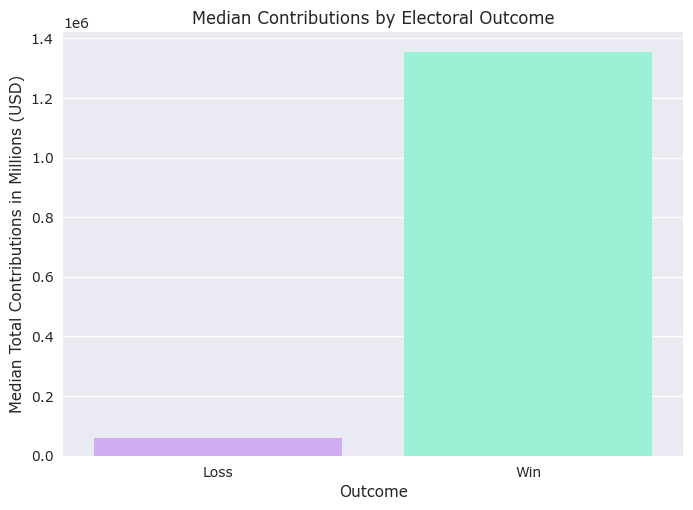

In [112]:
med_rec_by_outcome = [house[house['winner']==0]['tot_rec'].median(), house[house['winner']==1]['tot_rec'].median()]

sns.barplot(data=pd.DataFrame(med_rec_by_outcome), x=[0,1], y=med_rec_by_outcome, palette=['#cea2fd','#8cffdb'], errorbar=None)

plt.title('Median Contributions by Electoral Outcome')
plt.xlabel('Outcome')
plt.ylabel('Median Total Contributions in Millions (USD)')
plt.xticks(ticks=[0,1], labels=['Loss','Win'])

([<matplotlib.axis.XTick at 0x17d109c96d0>,
 [Text(0, 0, 'Losers'), Text(1, 0, 'Winners')])

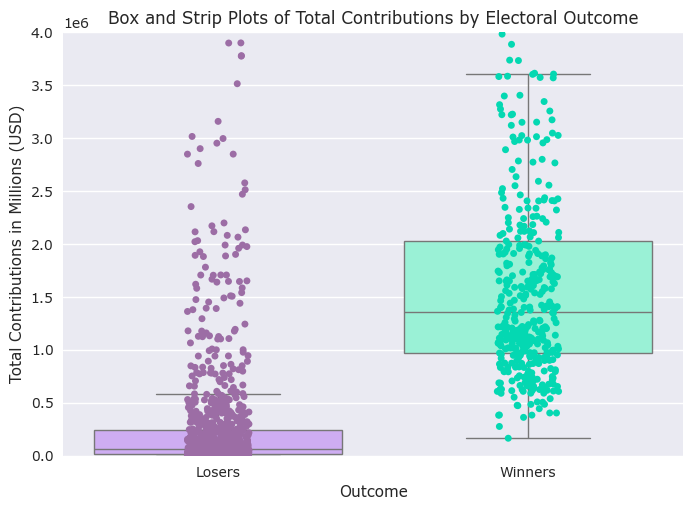

In [113]:
fig, ax = plt.subplots()

# Plot restricted to exclude 18 outliers (constituting approximately 1.3% of the dataset) exceeding $4,000,000 to produce 
# a more informative display
ax.set(ylim=(0, 4000000)) 

ax = sns.boxplot(data=house, x='winner', y='tot_rec', showfliers=False, palette=['#cea2fd','#8cffdb'])

ax = sns.stripplot(data=house, x='winner', y='tot_rec', palette=['#9c6da5','#04d8b2'])

plt.title('Box and Strip Plots of Total Contributions by Electoral Outcome')
plt.xlabel('Outcome')
plt.ylabel('Total Contributions in Millions (USD)')
plt.xticks(ticks=[0,1], labels=['Losers','Winners'])

#### Focus on the Two Ruling Parties

In [114]:
duopoly = house.query("party in ['Democrat', 'Republican']")

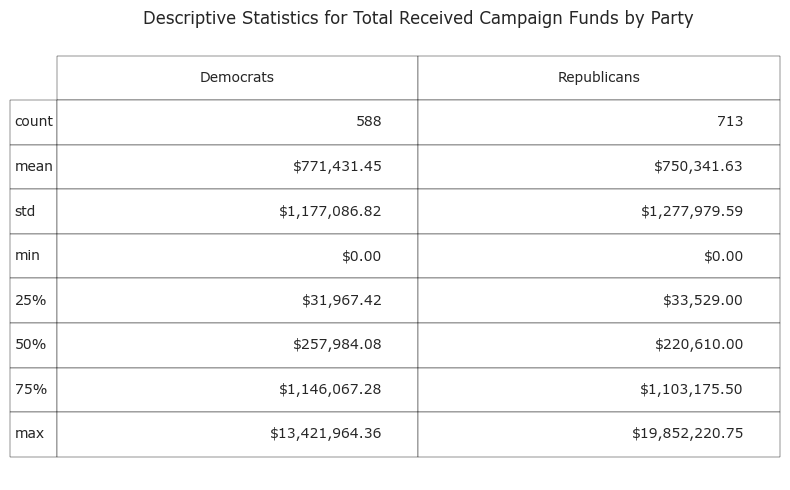

In [115]:
describe_dem = house[house['party']=='Democrat']['tot_rec'].describe().apply(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
describe_dem.loc['count'] = describe_dem.loc['count'].replace('$','').split('.')[0]

describe_rep = house[house['party']=='Republican']['tot_rec'].describe().apply(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
describe_rep.loc['count'] = describe_rep.loc['count'].replace('$','').split('.')[0]

des_party = pd.concat([describe_dem, describe_rep], axis='columns')

fig, ax = plt.subplots(figsize=(8, 5))

plt.rcParams['font.family'] = 'Verdana'
ax.axis('off'), ax.axis('tight')
table = ax.table(cellText=des_party.values.tolist(),rowLabels=des_party.index,colLabels=['Democrats','Republicans'],
                   loc='center')
table.scale(1,2.3)
plt.title('Descriptive Statistics for Total Received Campaign Funds by Party')

fig.tight_layout()

([<matplotlib.axis.XTick at 0x17d0617cb90>,
 [Text(0, 0, 'Loss'), Text(1, 0, 'Win')])

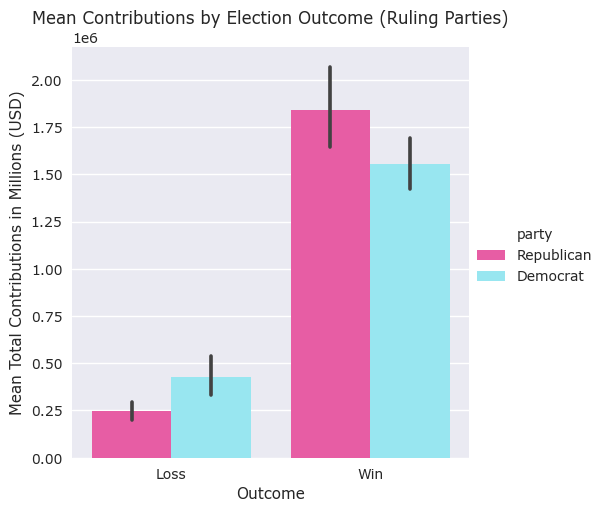

In [116]:
sns.catplot(data=duopoly, kind='bar', x='winner', y='tot_rec', hue='party', hue_order=['Republican','Democrat'], palette=['#fe46a5','#8af1fe'])

plt.title('Mean Contributions by Election Outcome (Ruling Parties)')
plt.xlabel('Outcome')
plt.ylabel('Mean Total Contributions in Millions (USD)')
plt.xticks(ticks=[0,1], labels=['Loss','Win'])

#### Association of Incumbency with Contributions and Outcome

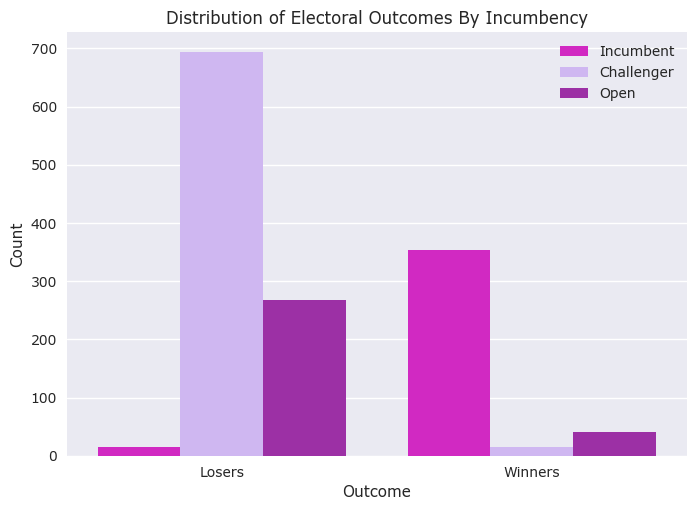

In [117]:
sns.countplot(data=house, x='winner', hue='inc', hue_order=['Incumbent','Challenger','Open'], palette=['#ed0dd9', '#ceaefa', '#ac1db8'])

plt.title('Distribution of Electoral Outcomes By Incumbency')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.xticks(ticks=[0,1], labels=['Losers','Winners'])
plt.gca().legend().set_title('')

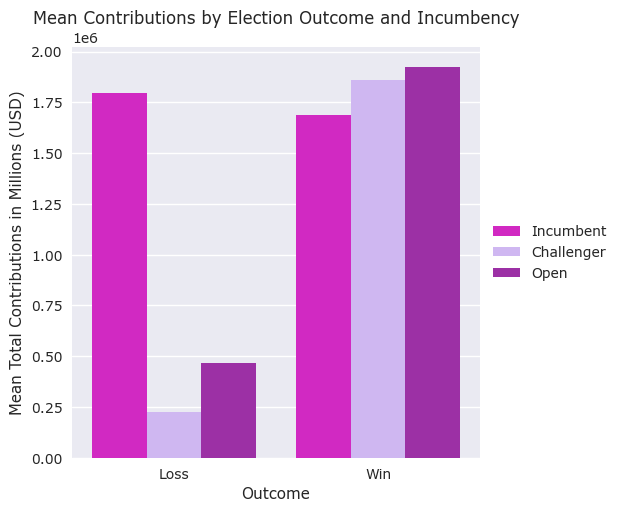

In [118]:
sns.catplot(data=house, kind='bar', x='winner', y='tot_rec', hue='inc', errorbar=None, hue_order=['Incumbent','Challenger','Open'],
            palette=['#ed0dd9', '#ceaefa', '#ac1db8'], legend=False)

plt.title('Mean Contributions by Election Outcome and Incumbency')
plt.xlabel('Outcome')
plt.ylabel('Mean Total Contributions in Millions (USD)')
plt.xticks(ticks=[0,1], labels=['Loss','Win'])
plt.legend(title='', labels=['Incumbent','Challenger','Open'], loc='center left', bbox_to_anchor=(1, 0.5))

([<matplotlib.axis.XTick at 0x17d06264190>,
 [Text(0, 0, 'Incumbent'), Text(1, 0, 'Challenger'), Text(2, 0, 'Open')])

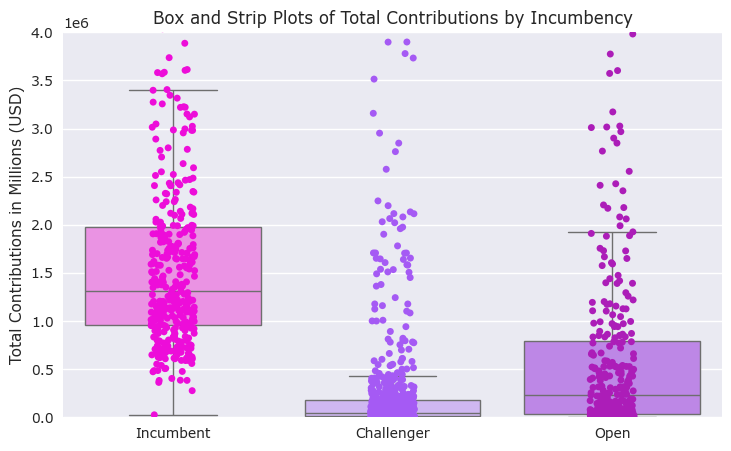

In [119]:
fig, ax = plt.subplots(figsize=(8.5,5))

# Plot restricted to exclude 18 outliers (constituting approximately 1.3% of the dataset) exceeding $4,000,000 to produce 
# a more informative display
ax.set(ylim=(0, 4000000))

ax = sns.boxplot(data=house, x='inc', y='tot_rec', showfliers=False, palette=['#f984ef', '#ceaefa', '#bf77f6'])

ax = sns.stripplot(data=house, x='inc', y='tot_rec', palette=['#ed0dd9', '#a55af4', '#ac1db8'])

plt.title('Box and Strip Plots of Total Contributions by Incumbency')
plt.xlabel('')
plt.ylabel('Total Contributions in Millions (USD)')
plt.xticks(ticks=[0,1,2], labels=['Incumbent','Challenger','Open'])

##### Incumbents

([<matplotlib.axis.XTick at 0x17d11b38190>,
 [Text(0, 0, 'Losers'), Text(1, 0, 'Winners')])

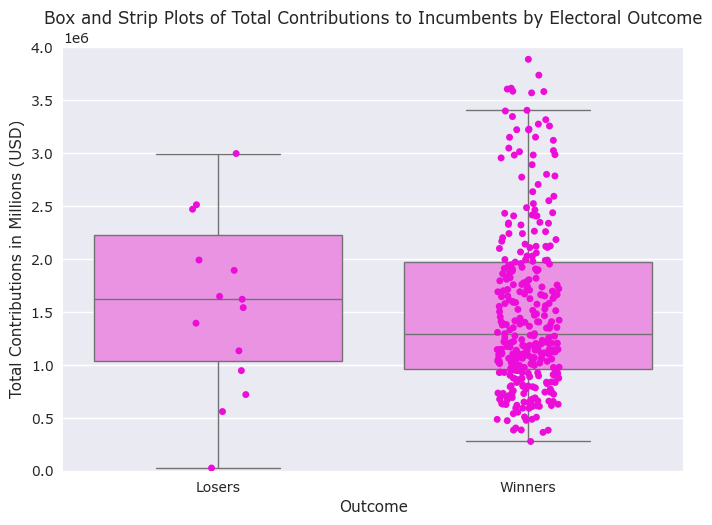

In [120]:
fig, ax = plt.subplots()

# Plot restricted to exclude 18 outliers (constituting approximately 1% of the dataset) exceeding $4,000,000 to produce 
# a more informative display
ax.set(ylim=(0, 4000000))

ax = sns.boxplot(data=house[house['inc']=='Incumbent'], x='winner', y='tot_rec', showfliers=False, palette=['#f984ef'])

ax = sns.stripplot(data=house[house['inc']=='Incumbent'], x='winner', y='tot_rec', palette=['#ed0dd9'])

plt.title('Box and Strip Plots of Total Contributions to Incumbents by Electoral Outcome')
plt.xlabel('Outcome')
plt.ylabel('Total Contributions in Millions (USD)')
plt.xticks(ticks=[0,1], labels=['Losers','Winners'])

In [121]:
house[house['inc']=='Incumbent'][house['winner']==0]['name'].sort_values()



874          brad ashford
302         corrine brown
952         cresent hardy
348           david jolly
1353        edward rigell
880          frank guinta
321             john mica
452            kyle takai
105            mike honda
788      patrick nunnelee
1360         randy forbes
812         renee ellmers
508           robert dold
903         scott garrett
571     timothy huelskamp
Name: name, dtype: object

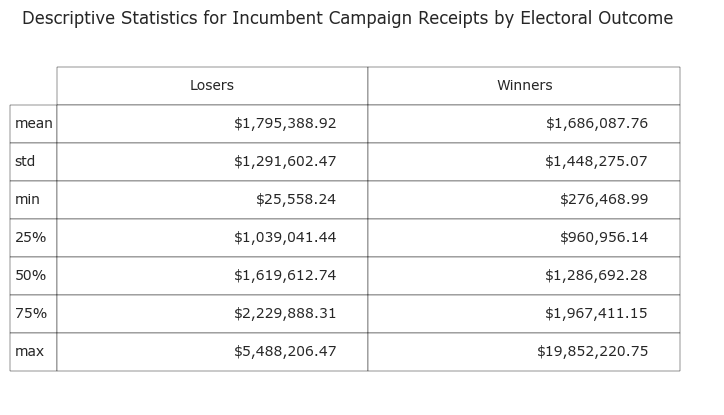

In [122]:
incumbent = house[house['inc']=='Incumbent']

describe_losers = incumbent[incumbent['winner']==0]['tot_rec'].describe().apply(lambda x: f'${x:,.2f}' if isinstance(x, (int, float)) else x).drop('count', axis='index')

describe_winners = incumbent[incumbent['winner']==1]['tot_rec'].describe().apply(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x).drop('count', axis='index')

des = pd.concat([describe_losers, describe_winners], axis='columns')

fig, ax = plt.subplots(figsize=(7,4.25))

plt.rcParams['font.family'] = 'Verdana'
ax.axis('off'), ax.axis('tight')
table = ax.table(cellText=des.values.tolist(), rowLabels=des.index, colLabels=['Losers','Winners'], loc='center')
table.scale(1,2)
plt.title('Descriptive Statistics for Incumbent Campaign Receipts by Electoral Outcome       ')

fig.tight_layout()

##### Challengers

([<matplotlib.axis.XTick at 0x17d12082d50>,
 [Text(0, 0, 'Losers'), Text(1, 0, 'Winners')])

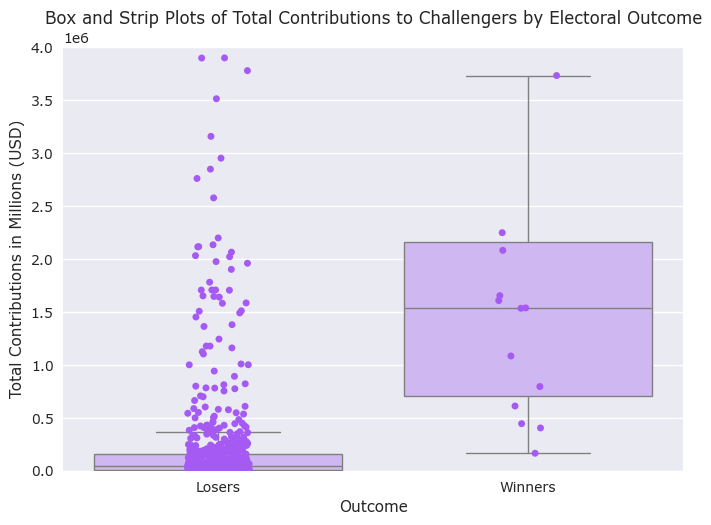

In [123]:
fig, ax = plt.subplots()

# Plot restricted to exclude 18 outliers (constituting approximately 1.3% of the dataset) exceeding $4,000,000 to produce 
# a more informative display
ax.set(ylim=(0, 4000000))

ax = sns.boxplot(data=house[house['inc']=='Challenger'], x='winner', y='tot_rec', showfliers=False, palette=['#ceaefa'])

ax = sns.stripplot(data=house[house['inc']=='Challenger'], x='winner', y='tot_rec', palette=['#a55af4'])

plt.title('Box and Strip Plots of Total Contributions to Challengers by Electoral Outcome')
plt.xlabel('Outcome')
plt.ylabel('Total Contributions in Millions (USD)')
plt.xticks(ticks=[0,1], labels=['Losers','Winners'])

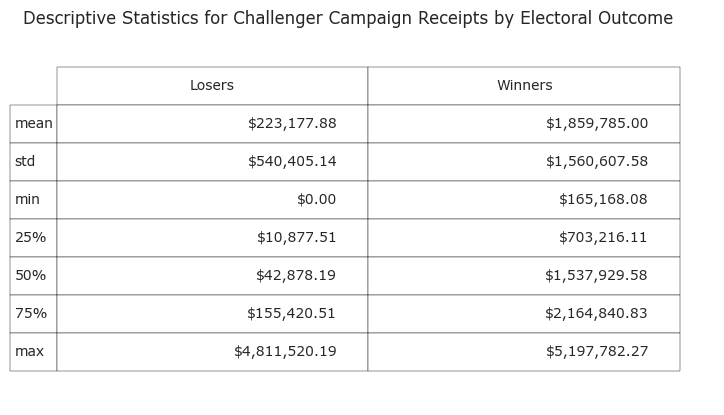

In [124]:
challenger = house[house['inc']=='Challenger']

describe_losers = challenger[challenger['winner']==0]['tot_rec'].describe().apply(lambda x: f'${x:,.2f}' if isinstance(x, (int, float)) else x).drop('count', axis='index')

describe_winners = challenger[challenger['winner']==1]['tot_rec'].describe().apply(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x).drop('count', axis='index')

des = pd.concat([describe_losers, describe_winners], axis='columns')

fig, ax = plt.subplots(figsize=(7,4.25))

plt.rcParams['font.family'] = 'Verdana'
ax.axis('off'), ax.axis('tight')
table = ax.table(cellText=des.values.tolist(), rowLabels=des.index, colLabels=['Losers','Winners'], loc='center')
table.scale(1,2)
plt.title('Descriptive Statistics for Challenger Campaign Receipts by Electoral Outcome       ')

fig.tight_layout()

##### Open Seat Contenders

([<matplotlib.axis.XTick at 0x17d12179950>,
 [Text(0, 0, 'Losers'), Text(1, 0, 'Winners')])

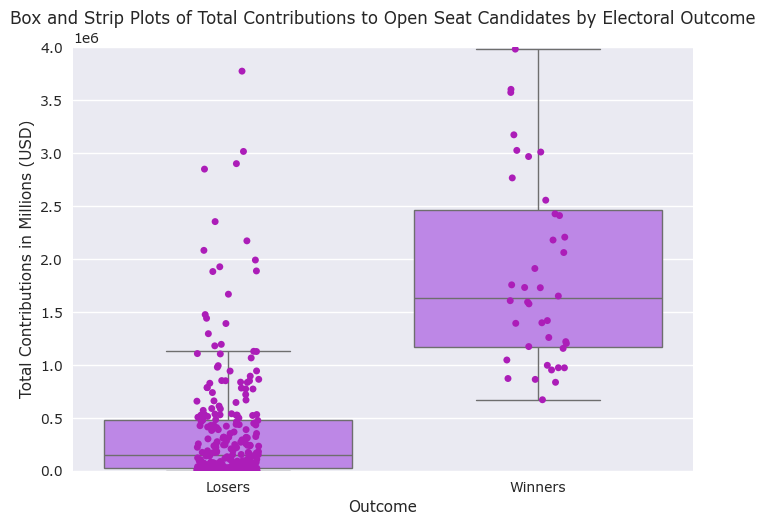

In [125]:
fig, ax = plt.subplots()

# Plot restricted to exclude 18 outliers (constituting approximately 1.3% of the dataset) exceeding $4,000,000 to produce 
# a more informative display
ax.set(ylim=(0, 4000000))

ax = sns.boxplot(data=house[house['inc']=='Open'], x='winner', y='tot_rec', showfliers=False, palette=['#bf77f6'])

ax = sns.stripplot(data=house[house['inc']=='Open'], x='winner', y='tot_rec', palette=['#ac1db8'])

plt.title('Box and Strip Plots of Total Contributions to Open Seat Candidates by Electoral Outcome')
plt.xlabel('Outcome')
plt.ylabel('Total Contributions in Millions (USD)')
plt.xticks(ticks=[0,1], labels=['Losers','Winners'])

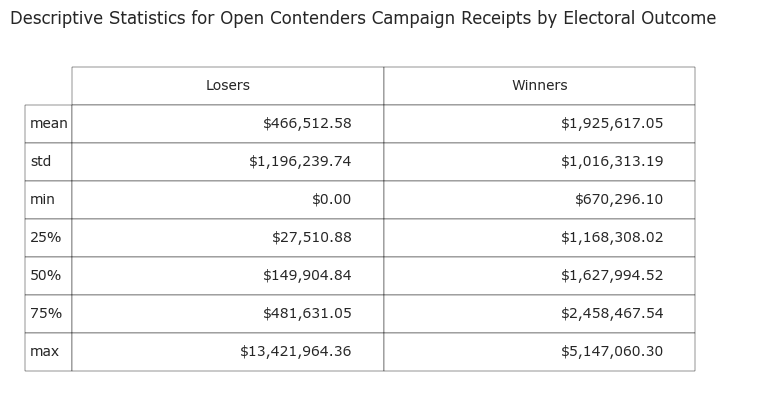

In [126]:
open_ = house[house['inc']=='Open']

describe_losers = open_[open_['winner']==0]['tot_rec'].describe().apply(lambda x: f'${x:,.2f}' if isinstance(x, (int, float)) else x).drop('count', axis='index')

describe_winners = open_[open_['winner']==1]['tot_rec'].describe().apply(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x).drop('count', axis='index')

des = pd.concat([describe_losers, describe_winners], axis='columns')

fig, ax = plt.subplots(figsize=(7,4.25))

plt.rcParams['font.family'] = 'Verdana'
ax.axis('off'), ax.axis('tight')
table = ax.table(cellText=des.values.tolist(), rowLabels=des.index, colLabels=['Losers','Winners'], loc='center')
table.scale(1,2)
plt.title('Descriptive Statistics for Open Contenders Campaign Receipts by Electoral Outcome       ')

fig.tight_layout()

### Parametric Analysis

In [127]:
lose_rec = house[house['winner']==0]['tot_rec']

win_rec = house[house['winner']==1]['tot_rec']


#### Check for Normality and Homoskedasticity 


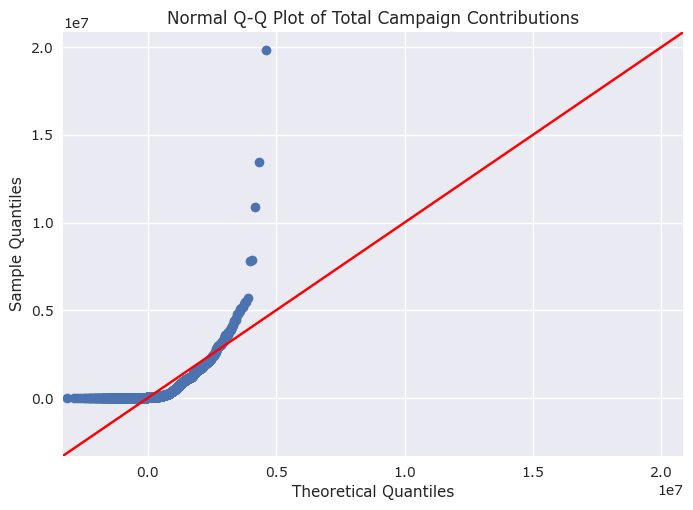

In [128]:
pp = sm.ProbPlot(house['tot_rec'], loc=np.mean(house['tot_rec']), scale=np.std(house['tot_rec']))

ax = pp.qqplot(line='45')

plt.title('Normal Q-Q Plot of Total Campaign Contributions')

plt.show()

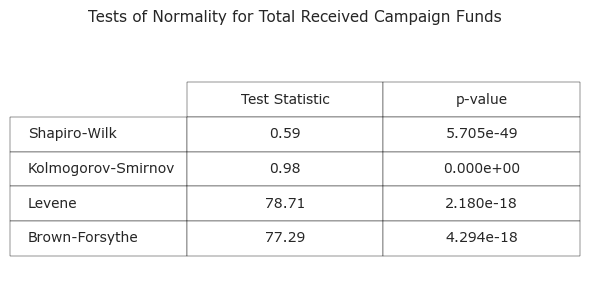

In [129]:
shapiro_wilk = list(map(str, list(stats.shapiro(house['tot_rec']))))

kolmogorov_smirnov = list(map(str, list(stats.kstest(house['tot_rec'], 'norm'))))

levene = list(map(str, list(stats.levene(lose_rec, win_rec, center='mean'))))

brown_forsythe = list(map(str, list(stats.levene(lose_rec, win_rec, center='median'))))

tests = [shapiro_wilk, kolmogorov_smirnov, levene, brown_forsythe] 

test_names = ['Shapiro-Wilk','Kolmogorov-Smirnov', 'Levene','Brown-Forsythe']

test_df = pd.DataFrame(data=tests, index=test_names, columns=['Test Statistic', 'p-value']).astype(float)

test_df['Test Statistic'] = test_df['Test Statistic'].round(2)

test_df['p-value'] = test_df['p-value'].apply(lambda x: f"{x:.3e}")

fig, ax = plt.subplots(figsize=(6, 3))

ax.axis('tight')
ax.axis('off')
plt.rcParams['font.family'] = 'Verdana'

table = ax.table(
    cellText=test_df.values,
    colLabels=test_df.columns,
    rowLabels=test_df.index,
    loc='center',
    cellLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
fig.suptitle('Tests of Normality for Total Received Campaign Funds', fontsize=11)
fig.tight_layout()

plt.show()

### Correlational Analysis and Non-Parametric Comparison Testing

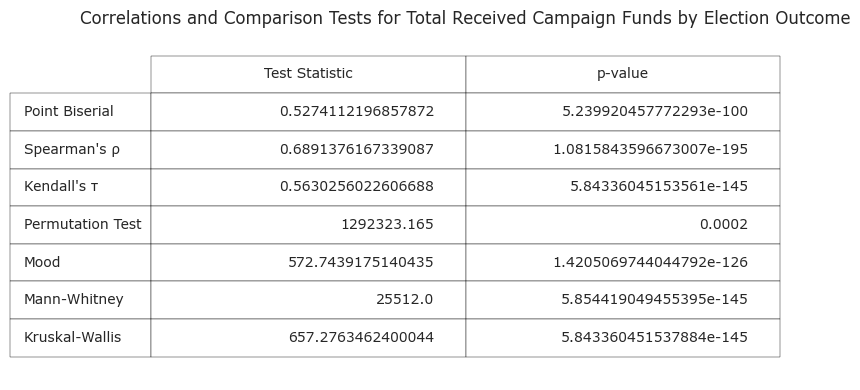

In [130]:
pearson = list(map(str, list(stats.pearsonr(house['tot_rec'],house['winner']))))

spearman = list(map(str, list(stats.spearmanr(house['tot_rec'],house['winner']))))

kendall = list(map(str, list(stats.kendalltau(house['tot_rec'],house['winner']))))

def statistic(x, y, axis):
    return np.median(x, axis=axis) - np.median(y, axis=axis)

pt = stats.permutation_test([win_rec, lose_rec], statistic)

perm = [pt.statistic, pt.pvalue]

mood = list(map(str, list(stats.median_test(lose_rec, win_rec))))[0:2]

mann_whitney = list(map(str, list(stats.mannwhitneyu(lose_rec, win_rec))))
               
kruskal_wallis = list(map(str, list(stats.kruskal(lose_rec,win_rec))))

tests = [pearson, spearman, kendall, perm, mood, mann_whitney, kruskal_wallis]

test_names = ["Point Biserial", "Spearman's ρ", "Kendall's τ", 'Permutation Test', 'Mood', 'Mann-Whitney','Kruskal-Wallis']

fig, ax = plt.subplots(figsize=(8, 4))

plt.rcParams['font.family'] = 'Verdana'
ax.axis('off'), ax.axis('tight')
table = ax.table(cellText=tests, colLabels=['Test Statistic','p-value'], rowLabels=test_names, loc='center')
table.scale(1,2)
plt.title('Correlations and Comparison Tests for Total Received Campaign Funds by Election Outcome')
fig.tight_layout()

### Sample Proportions and Tests of Independence

#### Proportion of Wins by Incumbency

In [131]:
h_inc = house[house['inc']=='Incumbent']
h_chal = house[house['inc']=='Challenger']
h_open = house[house['inc']=='Open']

p_inc = round(np.shape(h_inc[h_inc['winner']==1])[0] / np.shape(h_inc)[0], 3)
p_chal = round(np.shape(h_chal[h_chal['winner']==1])[0] / np.shape(h_chal)[0], 3)
p_open = round(np.shape(h_open[h_open['winner']==1])[0] / np.shape(h_open)[0], 3)

print('Proportion of incumbents who won:', p_inc)
print('Proportion of challenger who won:', p_chal)
print('Proportion of open contenders who won:', p_open)

Proportion of incumbents who won: 0.959
Proportion of challenger who won: 0.021
Proportion of open contenders who won: 0.13


#### Proportion of Wins by Incumbency Among Winners

In [132]:

h_inc = house[house['inc']=='Incumbent']
h_chal = house[house['inc']=='Challenger']
h_open = house[house['inc']=='Open']

p_inc = round(np.shape(h_inc[h_inc['winner']==1])[0] / np.shape(house[house['winner']==1])[0], 3)
p_chal = round(np.shape(h_chal[h_chal['winner']==1])[0] / np.shape(house[house['winner']==1])[0], 3)
p_open = round(np.shape(h_open[h_open['winner']==1])[0] / np.shape(house[house['winner']==1])[0], 3)

print('Proportion of incumbents among winners:', p_inc)
print('Proportion of challengers among winners:', p_chal)
print('Proportion of open contenders among winners:', p_open)

Proportion of incumbents among winners: 0.866
Proportion of challengers among winners: 0.037
Proportion of open contenders among winners: 0.098


#### Tests of Idependence

In [133]:
observed = pd.crosstab(index=house['inc'], columns=house['winner'])

display(observed)

winner,0.0,1.0
inc,,
Challenger,693,15
Incumbent,15,354
Open,268,40


In [134]:
expected = pd.DataFrame(stats.chi2_contingency(observed).expected_freq, index=['Challenger','Incumbent','Open'],
             columns=['Loss','Win']).round().astype(int)

display(expected)

,Loss,Win
Challenger,499,209
Incumbent,260,109
Open,217,91


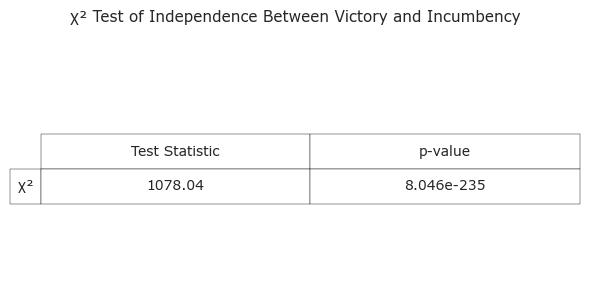

In [135]:
chi2 = list(map(str, [stats.chi2_contingency(observed).statistic, stats.chi2_contingency(observed).pvalue]))

tests = [chi2]

test_names = [" χ² "]

test_df = pd.DataFrame(data=tests, index=test_names, columns=['Test Statistic', 'p-value']).astype(float)

test_df['Test Statistic'] = test_df['Test Statistic'].round(2)

test_df['p-value'] = test_df['p-value'].apply(lambda x: f"{x:.3e}")

fig, ax = plt.subplots(figsize=(6, 3))

ax.axis('tight')
ax.axis('off')
plt.rcParams['font.family'] = 'Verdana'

table = ax.table(
    cellText=test_df.values,
    colLabels=test_df.columns,
    rowLabels=test_df.index,
    loc='center',
    cellLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
fig.suptitle('χ² Test of Independence Between Victory and Incumbency', fontsize=11)
fig.tight_layout()

plt.show()


### Covariate-Adjusted Logistic Regression Analysis

We now wish to determine the size of the effect of campaign funds in determining electoral outcomes while controlling for the confounding variable of incumbency. As the categorical dependent variable of electoral victory or loss $W$ is not amenable to such an analysis by means of, e.g., one-way ANCOVA, we make use of the Generalized Linear Model (GLM) with logit link

$$\text{logit}(P[W=1]) = \beta_0 + \beta_1 C + \beta_2 I$$

where (as noted above) the dichotomous response variable $W$ denotes electoral victory or loss; the continous explanatory variable $C$ denotes total campaign contributions; and the categorical covariate $I$ denotes incumbency, with $\beta_k$ for $k\in\{0,1,2\}$ denoting the affine model parameters. After fixing dummy variables for $I$ so as to associate $1$

However, as noted during Data Description and Visualization, there exists a substantial imbalance between the binary outcomes of $W$ in this dataset, which could limit the goodness of fit of our model. After a preliminary application of the model to the untrimmed and untransformed data, measures are subsequently taken to address this imbalance, which could introduce bias in our parameter estimates towards the majority response category (the losers).

In [136]:
inc_map = {'Open':0,'Challenger':1, 'Incumbent':2}

print('Winner count of untrimmed data:', np.shape(house[house['winner']==1])[0])
print('Loser count of untrimmed data:', np.shape(house[house['winner']==0])[0])
print('Incumbency counts:\n', house['inc'].value_counts().reindex(['Incumbent', 'Challenger', 'Open'], fill_value=0).rename_axis('') )
print()

house['inc'] = house['inc'].map(inc_map)

house['intercept'] = 1

model = sm.Logit(house['winner'], house[['intercept', 'tot_rec', 'inc']]) 
result = model.fit(cov_type='HC3')

print(result.summary())
print()

marginal_effects = result.get_margeff()
print(marginal_effects.summary())

house['inc'] = house['inc'].map({v:k for k,v in inc_map.items()})

house.drop('intercept', axis='columns', inplace=True)

Winner count of untrimmed data: 409
Loser count of untrimmed data: 976
Incumbency counts:
 
Incumbent     369
Challenger    708
Open          308
Name: count, dtype: int64

Optimization terminated successfully.
         Current function value: 0.250040
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 winner   No. Observations:                 1385
Model:                          Logit   Df Residuals:                     1382
Method:                           MLE   Df Model:                            2
Date:                Wed, 01 Jan 2025   Pseudo R-squ.:                  0.5880
Time:                        21:52:25   Log-Likelihood:                -346.30
converged:                       True   LL-Null:                       -840.47
Covariance Type:                  HC3   LLR p-value:                2.444e-215
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------

By virtue of the low $p$-values and decent pseudo-$R^2$ value $R_{\text{McFadden}}^2 = 0.588$ indicative of good model fit, the foregoing analysis reveals strong evidence for rejection of the null hypothesis that total received campaign contributions have no effect on electoral outcome after controlling for incumbency after upsampling winners. In particular, the present analysis yields a conditional odds ratio (OR) for $C$ of 

$$ e^{\beta_1} \approx 1.0000001386,$$

such that an additional $100,000.00 in campaign contributions multiplies a candidate's odds of victory by 

$$\exp(100000 \cdot 0.0000001386) \approx 1.1487$$

i.e., **an additional $100,000.00 in campaign contributions increases a candidate's odds of victory by about 14.87% after controlling for the potentially confounding variable of candidate incumbency**.

#### SMOTE

In [137]:
from imblearn.over_sampling import SMOTE

house['inc'] = house['inc'].map(inc_map)

X = house[['tot_rec', 'inc']]
y = house['winner']

smote = SMOTE(random_state=137)
X_smote, y_smote = smote.fit_resample(X, y)

house_smote = pd.DataFrame(X_smote, columns=X.columns)
house_smote['winner'] = y_smote
house_smote['intercept'] = 1

print('Winner count after resampling:', np.shape(house_smote[house_smote['winner']==1])[0])
print('Loser count after resampling:', np.shape(house_smote[house_smote['winner']==0])[0])
house_smote['inc'] = house_smote['inc'].map({v:k for k,v in inc_map.items()})
print('Incumbency counts:\n', house_smote['inc'].value_counts().reindex(['Incumbent', 'Challenger', 'Open'], fill_value=0).rename_axis('') )
house_smote['inc'] = house_smote['inc'].map(inc_map)
print('')
print()

model = sm.Logit(house_smote['winner'], house_smote[['intercept', 'tot_rec', 'inc']]) 
result = model.fit(cov_type='HC3')

print(result.summary())
print()

marginal_effects = result.get_margeff()
print(marginal_effects.summary())

house['inc'] = house['inc'].map({v:k for k,v in inc_map.items()})

Winner count after resampling: 976
Loser count after resampling: 976
Incumbency counts:
 
Incumbent     773
Challenger    798
Open          381
Name: count, dtype: int64


Optimization terminated successfully.
         Current function value: 0.299869
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 winner   No. Observations:                 1952
Model:                          Logit   Df Residuals:                     1949
Method:                           MLE   Df Model:                            2
Date:                Wed, 01 Jan 2025   Pseudo R-squ.:                  0.5674
Time:                        21:52:25   Log-Likelihood:                -585.34
converged:                       True   LL-Null:                       -1353.0
Covariance Type:                  HC3   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------

The low $p$-values and solid pseudo-$R^2$ value $R_{\text{McFadden}}^2 = 0.5674$ indicate similarly good model fit relative to the untransformed case above, again providing strong evidence for rejection of the null hypothesis that total received campaign contributions have no effect on electoral outcome after controlling for incumbency after upsampling winners. In particular, the present analysis yields a conditional odds ratio (OR) for $C$ of 

$$ e^{\beta_1} \approx 1.0000002084,$$

such that an additional $100,000.00 in campaign contributions multiplies a candidate's odds of victory by 

$$\exp(100000 \cdot 0.0000002084) \approx 1.2317$$

i.e., **an additional $100,000.00 in campaign contributions increases a candidate's odds of victory by about 23.17% after controlling for the potentially confounding variable of candidate incumbency**.

#### Variance Inflation Factor (Untransformed Data)

In [138]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

house['inc'] = house['inc'].map(inc_map)

X = house.copy(deep=True)
X = X[['tot_rec','inc']]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

house['inc'] = house['inc'].map({v:k for k,v in inc_map.items()})

  Variable       VIF
0  tot_rec  1.510772
1      inc  1.510772


#### Variance Inflation Factor (Upsampled Data)

In [139]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = house_smote.copy(deep=True)
X = X[['tot_rec','inc']]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

  Variable       VIF
0  tot_rec  1.715168
1      inc  1.715168


As can be seen from the above output, the VIFs associated with $C$ and $I$ are quite low in both the untransformed and upsampled data, indicating low multicollinearity between $C$ and $I$.

### Focus on Challengers and Open Contenders

The analysis which follows makes use of a modified dataset excluding incumbent candidates and a variant of the above GLM

$$\text{logit}(P[W=1]) = \gamma_0 + \gamma_1 C + \gamma_2 I^*$$

where (as noted above) the dichotomous response variable $W$ denotes electoral victory or loss; the continous explanatory variable $C$ denotes total campaign contributions; and the categorical covariate $I^*\in \{\text{Challenger},\text{Open}\}$ indicates whether the candidate was a challenger or open seat contender, with $\gamma_k$ for $k\in\{0,1,2\}$ denoting the affine model parameters.

In [140]:
house_oc = house[house['inc']!='Incumbent']

house_oc['inc'] = house_oc['inc'].map(inc_map)

X = house_oc[['tot_rec', 'inc']]
y = house_oc['winner']

smote = SMOTE(random_state=137)
X_smote, y_smote = smote.fit_resample(X, y)

house_oc_smote = pd.DataFrame(X_smote, columns=X.columns)
house_oc_smote['winner'] = y_smote
house_oc_smote['intercept'] = 1

print('Winner count after resampling:', np.shape(house_oc_smote[house_oc_smote['winner']==1])[0])
print('Loser count after resampling:', np.shape(house_oc_smote[house_oc_smote['winner']==0])[0])
house_oc_smote['inc'] = house_oc_smote['inc'].map({v:k for k,v in inc_map.items()})
print('Incumbency counts:\n', house_oc_smote['inc'].value_counts().reindex(['Incumbent', 'Challenger', 'Open'], fill_value=0).rename_axis('') )
house_oc_smote['inc'] = house_oc_smote['inc'].map(inc_map)
print('')
print()

model = sm.Logit(house_oc_smote['winner'], house_oc_smote[['intercept','tot_rec', 'inc']]) 
result = model.fit(cov_type='HC3')

print(result.summary())
print()

marginal_effects = result.get_margeff()
print(marginal_effects.summary())

Winner count after resampling: 961
Loser count after resampling: 961
Incumbency counts:
 
Incumbent        0
Challenger     781
Open          1141
Name: count, dtype: int64


Optimization terminated successfully.
         Current function value: 0.312644
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 winner   No. Observations:                 1922
Model:                          Logit   Df Residuals:                     1919
Method:                           MLE   Df Model:                            2
Date:                Wed, 01 Jan 2025   Pseudo R-squ.:                  0.5489
Time:                        21:52:25   Log-Likelihood:                -600.90
converged:                       True   LL-Null:                       -1332.2
Covariance Type:                  HC3   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------

As can be seen in the above display, model fit to the restricted data as measured by $R_{\text{McFadden}}^2 = 0.5489$ is quite good compared to that of the preceding regressions. Together with the low $p$-values, this constitues strong evidence that total campaign receipts are indeed predictive of electoral outcome among challengers and open seat contenders after controlling for $I^*$. The conditional OR for $C$ of 

$$ e^{\gamma} \approx 1.000002093,$$

such that an additional $100,000.00 in campaign contributions multiplies a candidate's odds of victory by 

$$\exp(100000 \cdot 0.000002093) \approx 1.233,$$

i.e., **an additional $100,000.00 in campaign contributions increases a challenger's or open contender's odds of victory by about 23.3% after controlling for any effect of being a challenger or open seat contender**, consistent with the results obtained above.


### Assessment of Linear Separability with Single-Layer Perceptron

#### Untransformed Data

In [141]:
from sklearn.linear_model import Perceptron

perceptron = Perceptron(random_state=137)

X = house[['inc','tot_rec']]

X = pd.get_dummies(X)

y = house['winner'].astype(int)

perceptron.fit(X, y)

Perceptron(random_state=137)

              precision    recall  f1-score   support

           0       1.00      0.70      0.83      1385
           1       0.00      0.00      0.00         0

    accuracy                           0.70      1385
   macro avg       0.50      0.35      0.41      1385
weighted avg       1.00      0.70      0.83      1385



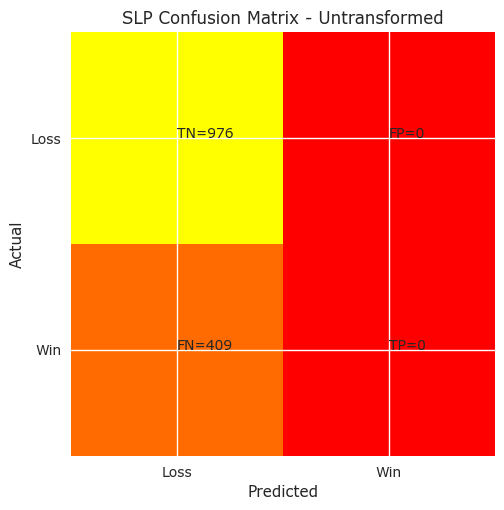

In [142]:
matrix = confusion_matrix(y, perceptron.predict(X))
 
plt.clf() 
plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.autumn)

plt.title('SLP Confusion Matrix - Untransformed')
plt.ylabel('Actual')
plt.xlabel('Predicted')

target = ['Loss','Win']
ticks = [0,1]
plt.xticks(ticks, target)
plt.yticks(ticks, target)

labels = [['TN','FP'], ['FN', 'TP']]
  
for j in range(2):
    for k in range(2):
        plt.text(k,j, str(labels[j][k]) + '=' + str(matrix[j][k]))
        
print(classification_report(perceptron.predict(X), y))
plt.show()

#### Rescaled Data - MinMaxScaler

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1000
           1       0.88      0.94      0.91       385

    accuracy                           0.95      1385
   macro avg       0.93      0.94      0.94      1385
weighted avg       0.95      0.95      0.95      1385



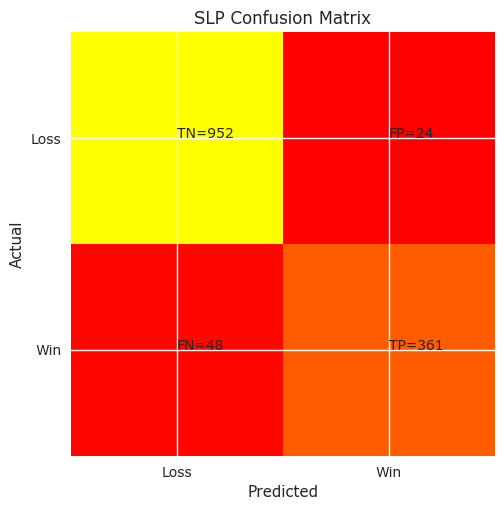

In [143]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()

X_mm = minmax.fit_transform(X)

perceptron.fit(X_mm, y)

matrix = confusion_matrix(y, perceptron.predict(X_mm))

plt.clf() 
plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.autumn)

plt.title('SLP Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

target = ['Loss','Win']
ticks = [0,1]
plt.xticks(ticks, target)
plt.yticks(ticks, target)

labels = [['TN','FP'], ['FN', 'TP']]
  
for j in range(2):
    for k in range(2):
        plt.text(k,j, str(labels[j][k]) + '=' + str(matrix[j][k]))

print(classification_report(perceptron.predict(X_mm), y))
plt.show()

#### RobustScaler

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1014
           1       0.87      0.95      0.91       371

    accuracy                           0.95      1385
   macro avg       0.92      0.95      0.94      1385
weighted avg       0.95      0.95      0.95      1385



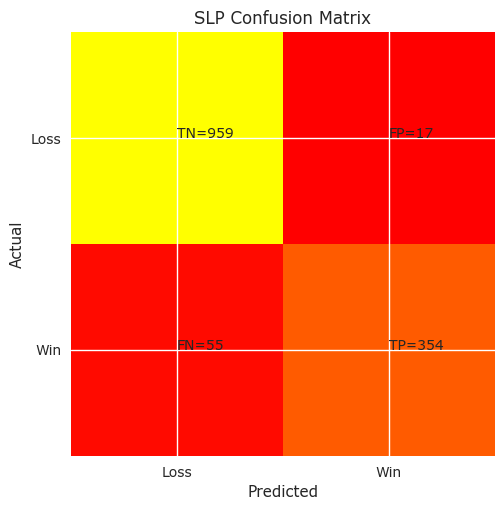

In [144]:
from sklearn.preprocessing import RobustScaler

robust = RobustScaler()

X_rs = robust.fit_transform(X)

perceptron.fit(X_rs, y)

matrix = confusion_matrix(y, perceptron.predict(X_rs))

plt.clf() 
plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.autumn)

plt.title('SLP Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

target = ['Loss','Win']
ticks = [0,1]
plt.xticks(ticks, target)
plt.yticks(ticks, target)

labels = [['TN','FP'], ['FN', 'TP']]
  
for j in range(2):
    for k in range(2):
        plt.text(k,j, str(labels[j][k]) + '=' + str(matrix[j][k]))

print(classification_report(perceptron.predict(X_rs), y))
plt.show()

### Algorithmic Classification and Outcome Prediction

In [145]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

In [146]:
def optimizer(algorithm, param_grid, X, y):
    
    alg = algorithm
    
    gs = GridSearchCV(algorithm, param_grid).fit(X, y)
    
    alg_opt = alg.set_params(**gs.best_params_)
    
    return alg_opt

#### Preprocessing

In [147]:
from sklearn.model_selection import train_test_split

X = house[['inc','tot_rec']]

X = pd.get_dummies(X)

y = house['winner'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=137)

minmax = MinMaxScaler()

X_train_mm = minmax.fit_transform(X_train)

X_test_mm = minmax.transform(X_test)

#### Logistic Regression

In [148]:

log_grid =  {'C':[0.001,0.01,0.1,1,5,7.5,10], 'class_weight':[None,'balanced'], 'penalty':['l1','l2']}

logreg = optimizer(LogisticRegression(), log_grid, X_train_mm, y_train)

logreg.fit(X_train_mm, y_train)

print(logreg.coef_, logreg.intercept_)

[[ 9.86885362 -2.72299963  3.36880022 -1.20029969]] [-0.61498995]


In [149]:
print(classification_report(logreg.predict(X_test_mm), y_test))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       310
           1       0.89      0.97      0.93       106

    accuracy                           0.96       416
   macro avg       0.94      0.96      0.95       416
weighted avg       0.96      0.96      0.96       416



Text(0.5, 1.0, 'Logistic Regression Confusion Matrix')

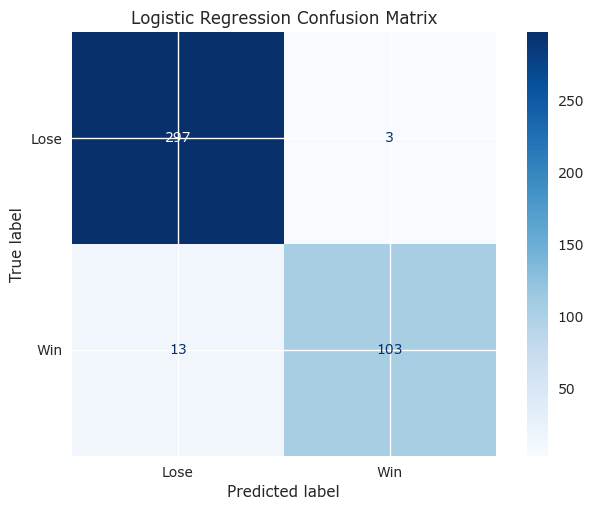

In [150]:

cm_logreg = confusion_matrix(y_test, logreg.predict(X_test_mm), labels=logreg.classes_)

ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=['Lose','Win']).plot(cmap=plt.cm.Blues)

plt.title('Logistic Regression Confusion Matrix')


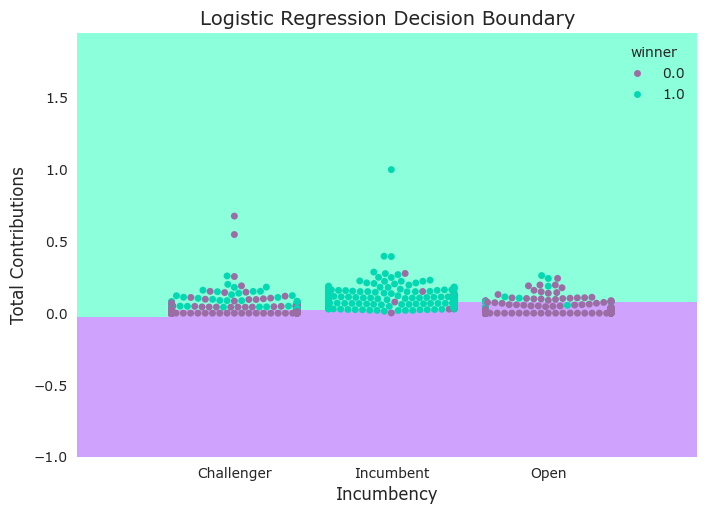

In [151]:

from matplotlib.colors import ListedColormap

H = house.copy(deep=True)

H['inc'] = H['inc'].map({'Incumbent':1,'Challenger':2,'Open':0})

H['tot_rec'] = ( H['tot_rec'] - min(H['tot_rec']) ) / ( max(H['tot_rec']) - min(H['tot_rec']) )

X = H[['inc','tot_rec']]

y = H['winner']

h = .05  

cmap_light = ListedColormap(['#cea2fd','#8cffdb'])
cmap_bold = ListedColormap(['#9c6da5','#04d8b2'])

clf = LogisticRegression(C=5, class_weight='balanced', penalty='l2')
clf.fit(X, y)

x_min, x_max = X['inc'].min() - 1, X['inc'].max() + 1
y_min, y_max = X['tot_rec'].min() - 1, X['tot_rec'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

sns.swarmplot(data=H, x='inc', y='tot_rec', hue='winner', palette=['#9c6da5','#04d8b2'])
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('Logistic Regression Decision Boundary', fontsize=14)
plt.xticks(ticks=[0,1,2], labels=['Challenger','Incumbent','Open'])
plt.xlabel('Incumbency', fontsize=12)
plt.ylabel('Total Contributions', fontsize=12)

plt.show()


#### K-Nearest Neighbor

In [152]:
knn_grid = {'n_neighbors':range(1,100)}

knn = optimizer(KNeighborsClassifier(), knn_grid, X_train_mm, y_train)

knn.fit(X_train_mm, y_train)

KNeighborsClassifier(n_neighbors=9)

In [153]:
print(classification_report(y_test, knn.predict(X_test_mm)))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       300
           1       0.93      0.90      0.91       116

    accuracy                           0.95       416
   macro avg       0.94      0.93      0.94       416
weighted avg       0.95      0.95      0.95       416



Text(0.5, 1.0, 'k-NN Confusion Matrix')

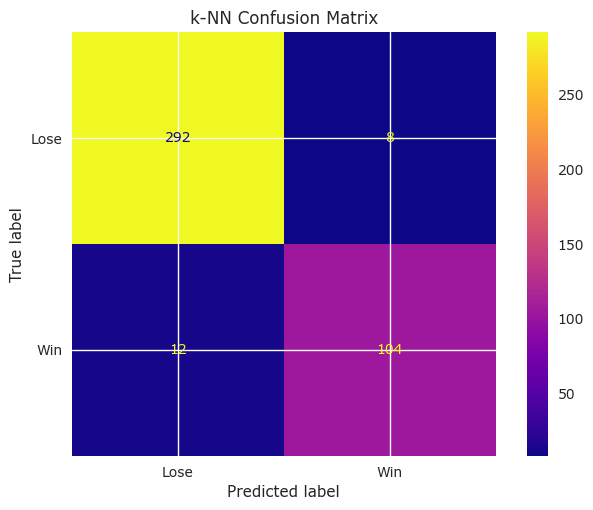

In [154]:
cm_knn = confusion_matrix(y_test, knn.predict(X_test_mm), labels=knn.classes_)

ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=['Lose','Win']).plot(cmap=plt.cm.plasma)

plt.title('k-NN Confusion Matrix')

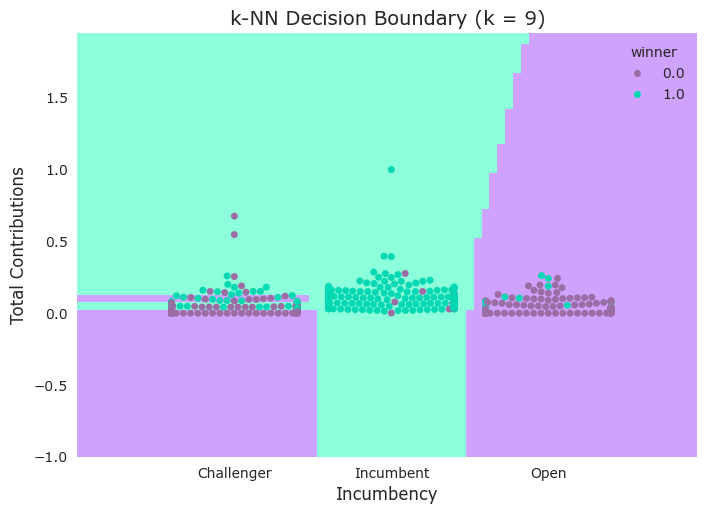

In [155]:
from matplotlib.colors import ListedColormap

H = house.copy(deep=True)

H['inc'] = H['inc'].map({'Incumbent':1,'Challenger':2,'Open':0})

H['tot_rec'] = ( H['tot_rec'] - min(H['tot_rec']) ) / ( max(H['tot_rec']) - min(H['tot_rec']) )

X = H[['inc','tot_rec']]

y = H['winner']

opt_k = knn.get_params()['n_neighbors']

h = .05  

cmap_light = ListedColormap(['#cea2fd','#8cffdb'])
cmap_bold = ListedColormap(['#9c6da5','#04d8b2'])

clf = KNeighborsClassifier(n_neighbors=opt_k)
clf.fit(X, y)

x_min, x_max = X['inc'].min() - 1, X['inc'].max() + 1
y_min, y_max = X['tot_rec'].min() - 1, X['tot_rec'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

sns.swarmplot(data=H, x='inc', y='tot_rec', hue='winner', palette=['#9c6da5','#04d8b2'])
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("k-NN Decision Boundary (k = {})".format(str(opt_k)), fontsize=14)
plt.xticks(ticks=[0,1,2], labels=['Challenger','Incumbent','Open'])
plt.xlabel('Incumbency', fontsize=12)
plt.ylabel('Total Contributions', fontsize=12)

plt.show()

#### Support Vector Machine

In [156]:
svc_grid = {'C':[0.01,0.1,0.25,0.5,0.75,1], 'kernel':['libear','rbf', 'sigmoid'],
            'gamma':['scale','auto']}

svc = optimizer(SVC(), svc_grid, X_train_mm, y_train)

svc.fit(X_train_mm, y_train)

SVC(C=0.01)

In [157]:
print(classification_report(svc.predict(X_test_mm), y_test))

              precision    recall  f1-score   support

           0       0.99      0.94      0.97       316
           1       0.84      0.98      0.91       100

    accuracy                           0.95       416
   macro avg       0.92      0.96      0.94       416
weighted avg       0.96      0.95      0.95       416



Text(0.5, 1.0, 'SVC Confusion Matrix')

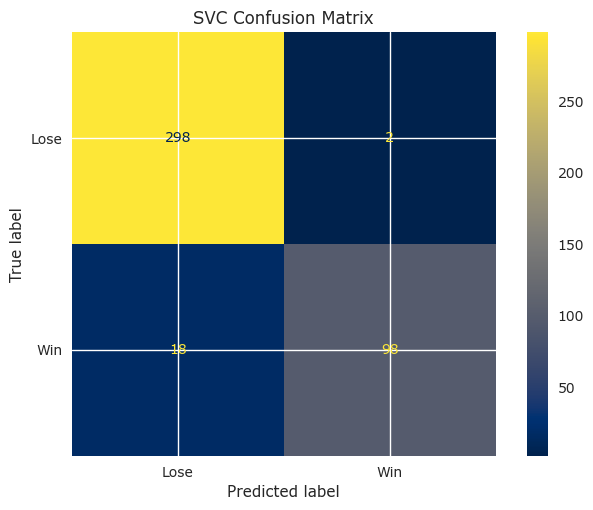

In [158]:
cm_svc = confusion_matrix(y_test, svc.predict(X_test_mm), labels=svc.classes_)

ConfusionMatrixDisplay(confusion_matrix=cm_svc, display_labels=['Lose','Win']).plot(cmap=plt.cm.cividis)

plt.title('SVC Confusion Matrix')

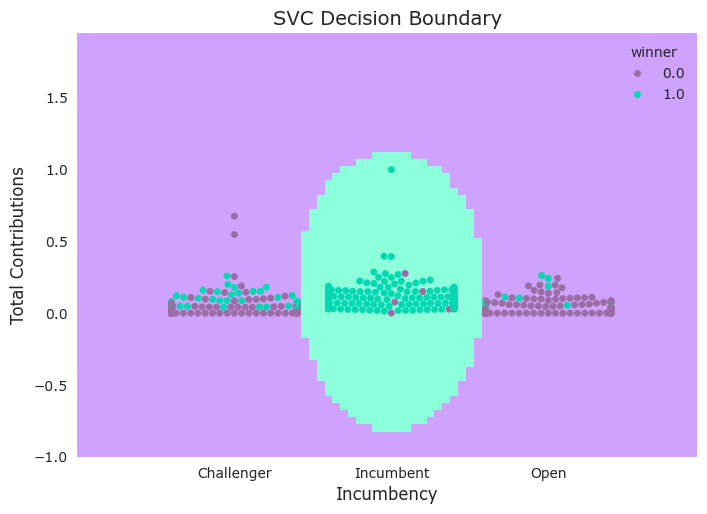

In [159]:
from matplotlib.colors import ListedColormap

H = house.copy(deep=True)

H['inc'] = H['inc'].map({'Incumbent':1,'Challenger':2,'Open':0})

H['tot_rec'] = ( H['tot_rec'] - min(H['tot_rec']) ) / ( max(H['tot_rec']) - min(H['tot_rec']) )

X = H[['inc','tot_rec']]

y = H['winner']

h = .05  

cmap_light = ListedColormap(['#cea2fd','#8cffdb'])
cmap_bold = ListedColormap(['#9c6da5','#04d8b2'])

clf = svc
clf.fit(X, y)

x_min, x_max = X['inc'].min() - 1, X['inc'].max() + 1
y_min, y_max = X['tot_rec'].min() - 1, X['tot_rec'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

sns.swarmplot(data=H, x='inc', y='tot_rec', hue='winner', palette=['#9c6da5','#04d8b2'])
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("SVC Decision Boundary", fontsize=14)
plt.xticks(ticks=[0,1,2], labels=['Challenger','Incumbent','Open'])
plt.xlabel('Incumbency', fontsize=12)
plt.ylabel('Total Contributions', fontsize=12)

plt.show()


#### Decision Tree

In [160]:
tree_grid = {'criterion':['gini','entropy','log_loss'], 'max_depth':range(2,10), 'ccp_alpha': [0.1,0.01,0.001,0]}

tree = optimizer(DecisionTreeClassifier(), tree_grid, X_train_mm, y_train)

tree.fit(X_train_mm, y_train)

DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=4)

In [161]:
print(classification_report(tree.predict(X_test_mm), y_test))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       304
           1       0.90      0.93      0.91       112

    accuracy                           0.95       416
   macro avg       0.93      0.94      0.94       416
weighted avg       0.95      0.95      0.95       416



Text(0.5, 1.0, 'Decision Tree Confusion Matrix')

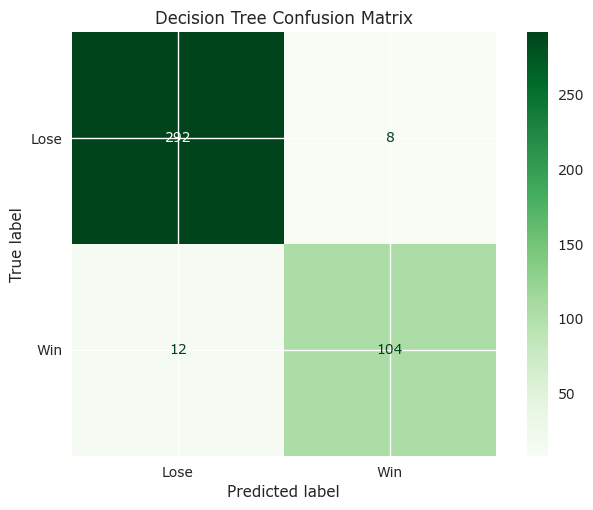

In [162]:
cm_tree = confusion_matrix(y_test, tree.predict(X_test_mm), labels=tree.classes_)

ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=['Lose','Win']).plot(cmap=plt.cm.Greens)

plt.title('Decision Tree Confusion Matrix')

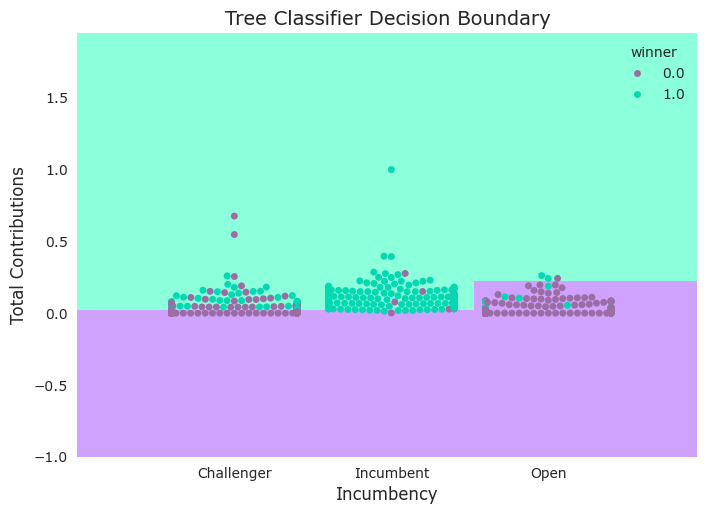

In [163]:

from matplotlib.colors import ListedColormap

H = house.copy(deep=True)

H['inc'] = H['inc'].map({'Incumbent':1,'Challenger':2,'Open':0})

H['tot_rec'] = ( H['tot_rec'] - min(H['tot_rec']) ) / ( max(H['tot_rec']) - min(H['tot_rec']) )

X = H[['inc','tot_rec']]

y = H['winner']

h = .05  

cmap_light = ListedColormap(['#cea2fd','#8cffdb'])
cmap_bold = ListedColormap(['#9c6da5','#04d8b2'])

clf = tree
clf.fit(X, y)

x_min, x_max = X['inc'].min() - 1, X['inc'].max() + 1
y_min, y_max = X['tot_rec'].min() - 1, X['tot_rec'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

sns.swarmplot(data=H, x='inc', y='tot_rec', hue='winner', palette=['#9c6da5','#04d8b2'])
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Tree Classifier Decision Boundary", fontsize=14)
plt.xticks(ticks=[0,1,2], labels=['Challenger','Incumbent','Open'])
plt.xlabel('Incumbency', fontsize=12)
plt.ylabel('Total Contributions', fontsize=12)

plt.show()


## Multilayer Perceptron

In [164]:
mlp_grid = {'hidden_layer_sizes':[(j,j,j) for j in range(10,30,10)], 'activation':['indentity','logistic','tanh','relu'], 
            'solver':['lbfgs','sgd','adam']}

mlp = optimizer(MLPClassifier(random_state=137), mlp_grid, X_train_mm, y_train)

mlp.fit(X_train_mm, y_train)

MLPClassifier(hidden_layer_sizes=(20, 20, 20), random_state=137, solver='lbfgs')

In [165]:
print(classification_report(mlp.predict(X_test_mm), y_test))

report_dict = classification_report(y_test, mlp.predict(X_test_mm), output_dict=True)

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       305
           1       0.89      0.93      0.91       111

    accuracy                           0.95       416
   macro avg       0.93      0.94      0.94       416
weighted avg       0.95      0.95      0.95       416



Text(0.5, 1.0, 'Triple-Layer Perceptron Confusion Matrix')

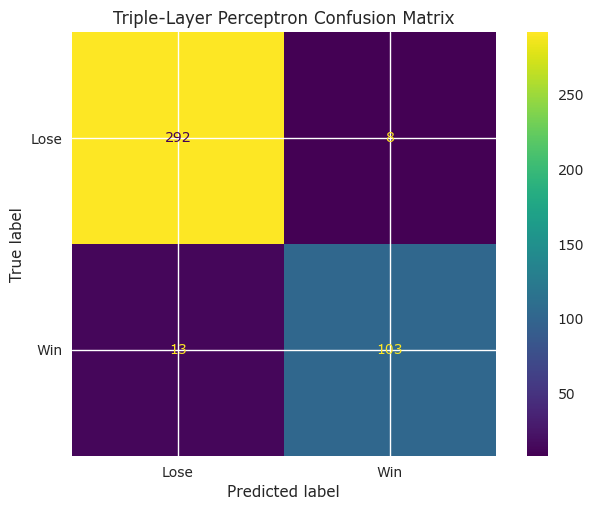

In [166]:
cm_mlp = confusion_matrix(y_test, mlp.predict(X_test_mm), labels=mlp.classes_)

ConfusionMatrixDisplay(confusion_matrix=cm_mlp, display_labels=['Lose','Win']).plot(cmap=plt.cm.viridis)

plt.title('Triple-Layer Perceptron Confusion Matrix')

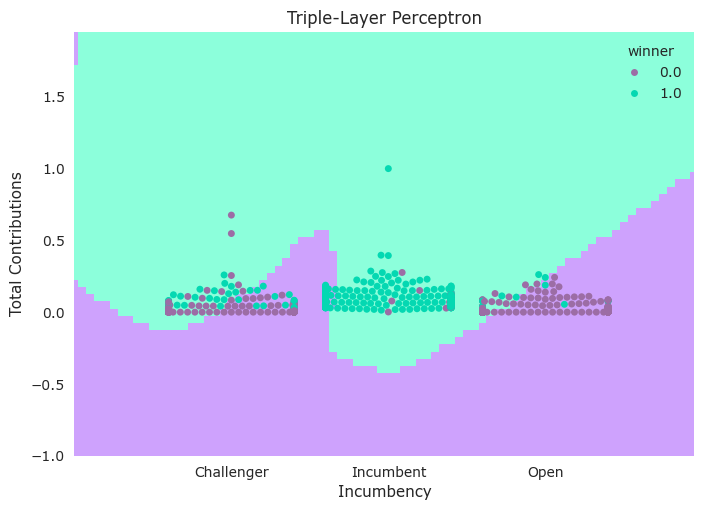

In [167]:
from matplotlib.colors import ListedColormap

H = house.copy(deep=True)

H['inc'] = H['inc'].map({'Incumbent':1,'Challenger':2,'Open':0})

H['tot_rec'] = ( H['tot_rec'] - min(H['tot_rec']) ) / ( max(H['tot_rec']) - min(H['tot_rec']) )

X = H[['inc','tot_rec']]

y = H['winner']

h = .05  

cmap_light = ListedColormap(['#cea2fd','#8cffdb'])
cmap_bold = ListedColormap(['#9c6da5','#04d8b2'])

clf = MLPClassifier(hidden_layer_sizes=(10,10,10), activation='logistic', solver='lbfgs', random_state=137)
clf.fit(X, y)

x_min, x_max = X['inc'].min() - 1, X['inc'].max() + 1
y_min, y_max = X['tot_rec'].min() - 1, X['tot_rec'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

sns.swarmplot(data=H, x='inc', y='tot_rec', hue='winner', palette=['#9c6da5','#04d8b2'])
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('Triple-Layer Perceptron')
plt.xticks(ticks=[0,1,2], labels=['Challenger','Incumbent','Open'])
plt.xlabel('Incumbency')
plt.ylabel('Total Contributions')

plt.show()